In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split

In [ ]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3], stds2 = [2, 1], covarianceMatrix1 = torch.eye(2), covarianceMatrix2 = torch.eye(2)):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    #covarianceMatrix = torch.eye(2)
    covarianceMatrix1[0, 0] = stds1[0]
    covarianceMatrix1[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix1, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix2[0, 0] = stds2[0]
    covarianceMatrix2[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix2, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.show()
    #Create samples without bias
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = torch.zeros(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAll)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples

In [ ]:
def build_distance_matrix_with_euclidean_distance(observation, centroids):
    # Here we are applying the mathematical operations of the Euclidean distance but operating through matrices
    observation_matrix = observation.repeat(centroids.shape[0],1)
    distances_matrix = centroids - observation_matrix
    distances_matrix_sum = torch.sum(distances_matrix, dim=1)
    distances_matrix_powed = torch.pow(distances_matrix_sum, 2)
    distances_matrix_final = torch.sqrt(distances_matrix_powed)
    return distances_matrix_final

def build_distance_matrix_with_manhattann_distance(observation, SamplesAll):
  # Here we are applying the mathematical operations of the Manhattan distance but operating through matrices
    observation_matrix = observation.repeat(SamplesAll.shape[0],1)
    distances_matrix = SamplesAll - observation_matrix
    distances_matrix = torch.abs(distances_matrix)
    distances_matrix_final = torch.sum(distances_matrix, dim=1)
    return distances_matrix_final

In [ ]:
def plot_centroids_clusters(centroids, data_clustered, plot_centroids_and_clusters = True, centroid_plot_size = 200):
  #Este primer escenario es solo para la primera iteracion de clusters randoms
  if plot_centroids_and_clusters == False:
    plt.scatter(data_clustered[:, 0], data_clustered[:, 1], color='pink')
  for centroid_idx in range(0, centroids.shape[0]) :
    cls = data_clustered[data_clustered[:, 0] == centroid_idx]
    if plot_centroids_and_clusters == True:
      plt.scatter(cls[:, 1], cls[:, 2])
    plt.scatter(centroids[centroid_idx, 0], centroids[centroid_idx, 1], centroid_plot_size)
  plt.show()

def set_new_centroid_position(data, weight_matriz, centroids, centroid_idx, clusters):
    #Obtenemos los indices de las observaciones que estan conectadas al centroide[centroid_idx]
    idxsOnes_Centroid = torch.nonzero(weight_matriz[:, centroid_idx]).reshape(-1)
    observations_closest_centroid = data[idxsOnes_Centroid]
    #Ahora creamos un vector "promedio" con todos las observaciones que estan cerca al centroide
    new_centroid = observations_closest_centroid.mean(dim=0)
    #seteamos el nuevo centroide
    centroids[centroid_idx] = new_centroid
    # Auxiliar del dato mas cercano al centroid
    clusters[idxsOnes_Centroid] = centroid_idx


In [ ]:
def KmeansImplementation(data, num_clusters, num_iterations, is_euclidian = True):
  #Primero debemos escoger al azar num_clusters centroides
  indices = torch.randint(0, data.shape[0], (num_clusters,))
  centroids = data[indices]

  #cluster_association lo usaremos como una columna que haremos append al dataset para poner el cluster al que pertenece cada observacion
  cluster_association = torch.zeros(data.shape[0], 1)

  for iter in range(0,num_iterations):

    plot_centroids_clusters(centroids, data, False)

    #Creamos matriz de pesos
    weight_matriz = torch.zeros(data.shape[0], centroids.shape[0])

    w_idx = 0
    for observation_point in data :
      distances = build_distance_matrix_with_euclidean_distance(observation_point, centroids) if is_euclidian == True else build_distance_matrix_with_manhattann_distance(observation_point, centroids)
      # El centroide mas cercano al punto de observacion
      closest_centroid_observation = torch.argmin(distances).item()
      # Ponemos un 1 en la columna del centroide mas cercano
      weight_matriz[w_idx, closest_centroid_observation] = 1.0
      w_idx += 1
    
    # Set first centroid position
    set_new_centroid_position(data, weight_matriz, centroids, 0, cluster_association)
    #Set second centroid position
    set_new_centroid_position(data, weight_matriz, centroids, 1, cluster_association)
  
  
  final_clustered_data = torch.cat((cluster_association, data), 1)
  plot_centroids_clusters(centroids, final_clustered_data)

  return final_clustered_data



def test_Kmeans(targets, samples, num_clusters, num_iterations, is_euclidian = True):
  final_data_clustered  = KmeansImplementation(samples, num_clusters, num_iterations, is_euclidian)
  targets_reshape = targets.reshape(-1)
  amount_right_estimations = torch.max((final_data_clustered[:, 0] == targets_reshape).sum(), (final_data_clustered[:, 0] != targets_reshape).sum())
  accuracy = amount_right_estimations / targets.shape[0]
  return accuracy.item()
    



X1 dataset


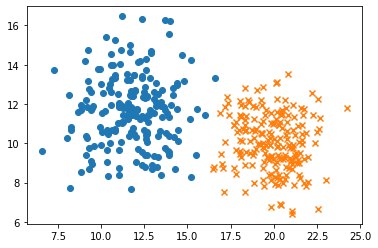

Running X1 dataset with euclidean distance


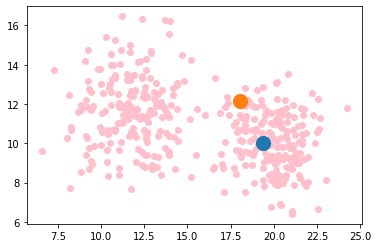

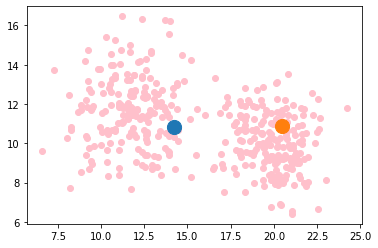

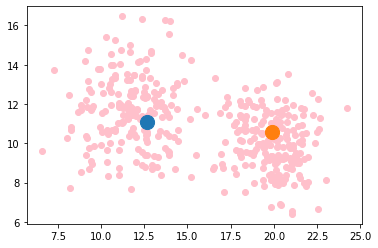

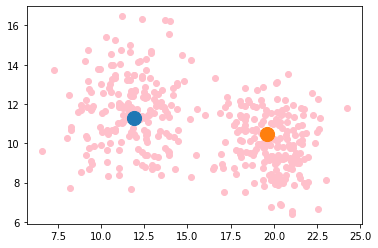

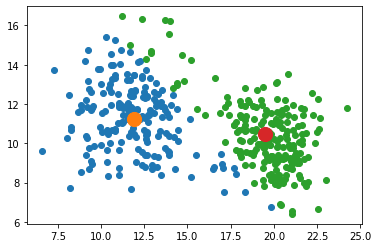

The accuracy for run # 0 is: 0.9300000071525574


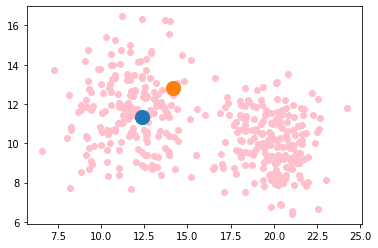

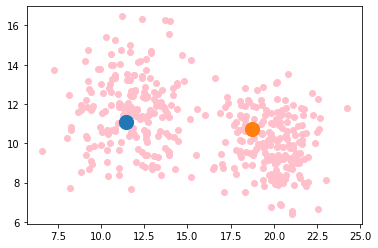

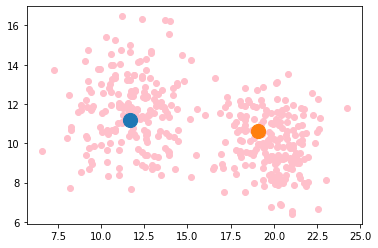

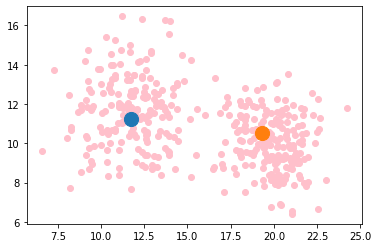

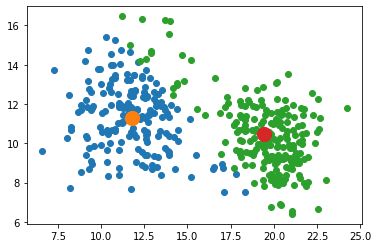

The accuracy for run # 1 is: 0.9325000047683716


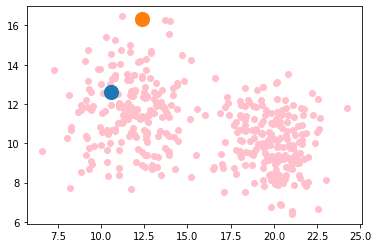

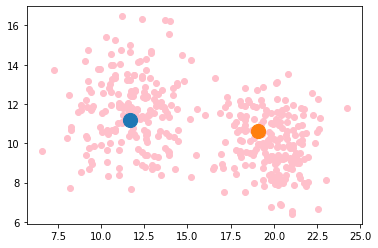

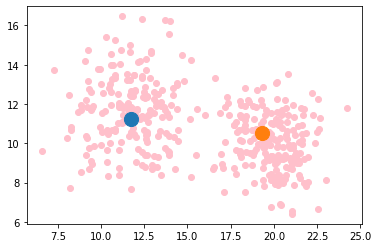

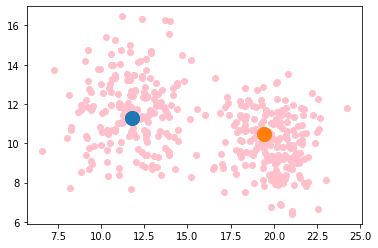

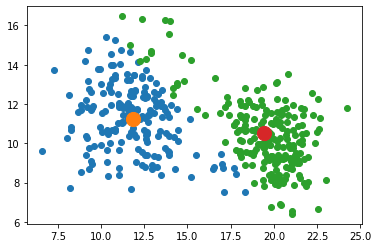

The accuracy for run # 2 is: 0.9275000095367432


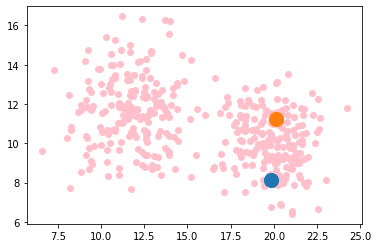

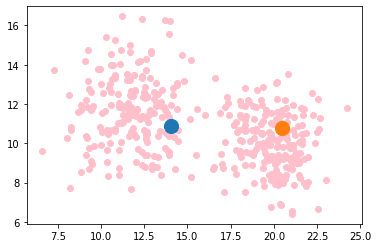

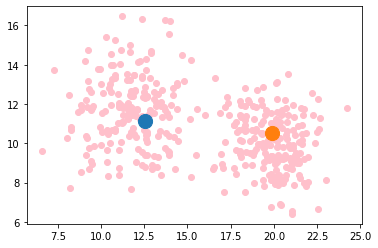

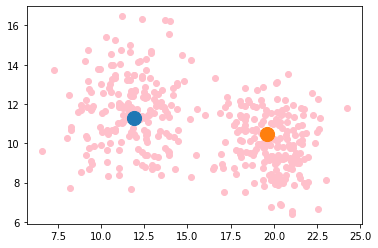

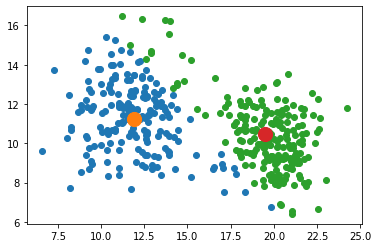

The accuracy for run # 3 is: 0.9300000071525574


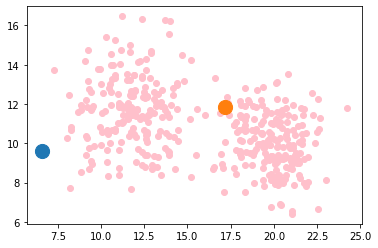

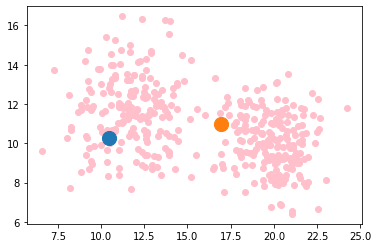

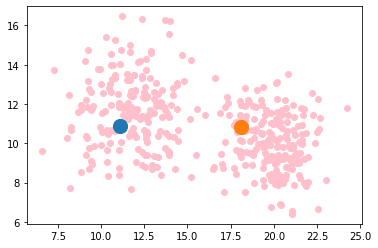

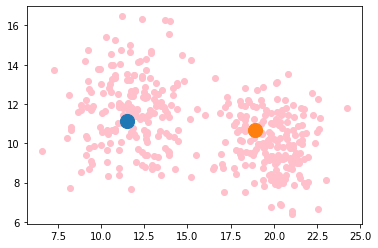

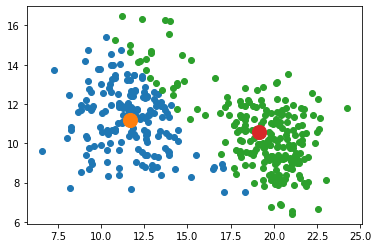

The accuracy for run # 4 is: 0.9125000238418579


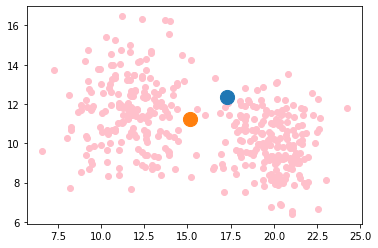

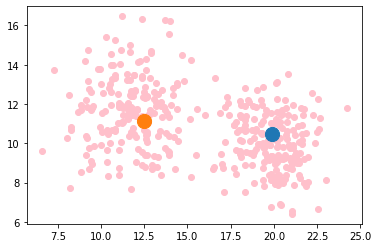

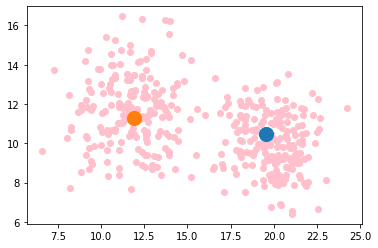

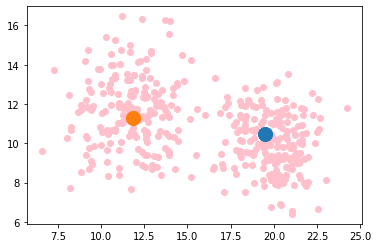

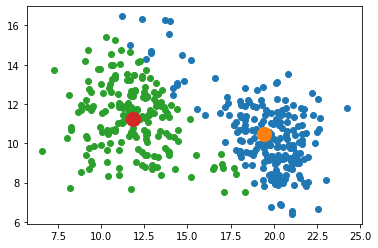

The accuracy for run # 5 is: 0.9300000071525574


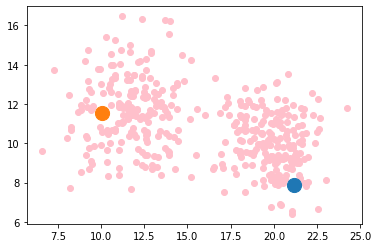

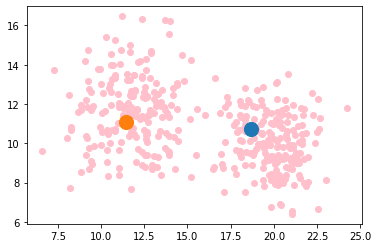

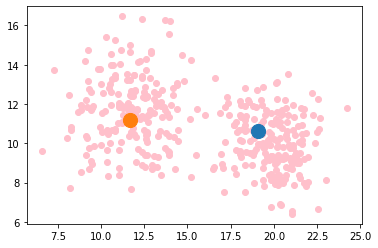

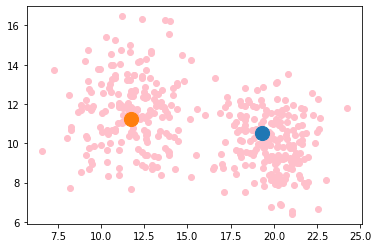

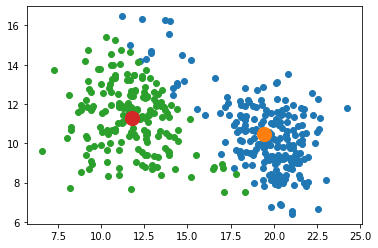

The accuracy for run # 6 is: 0.9325000047683716


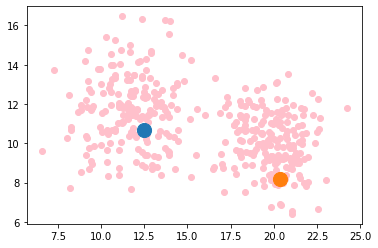

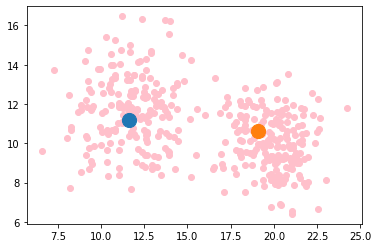

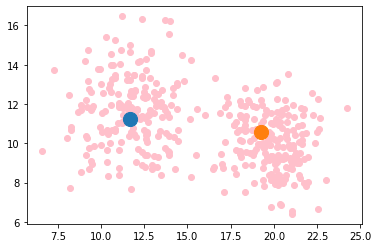

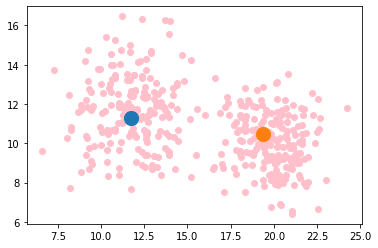

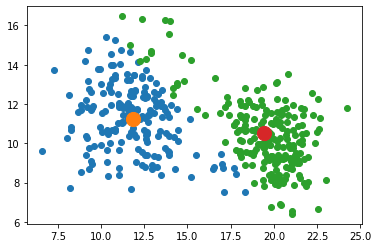

The accuracy for run # 7 is: 0.9275000095367432


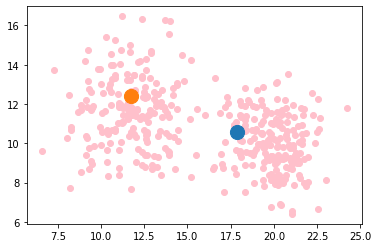

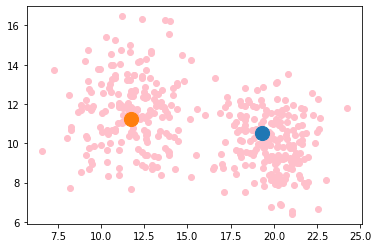

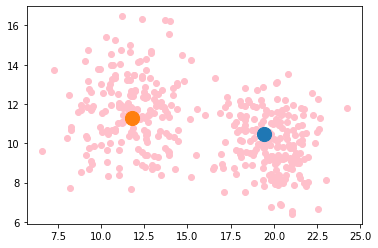

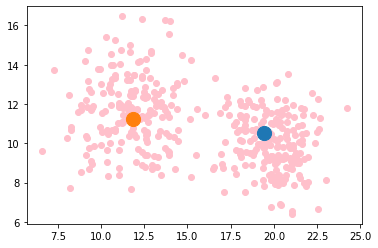

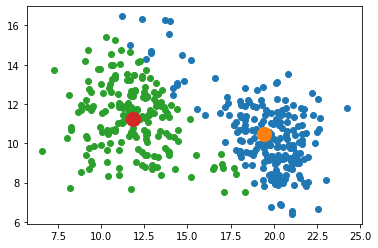

The accuracy for run # 8 is: 0.9300000071525574


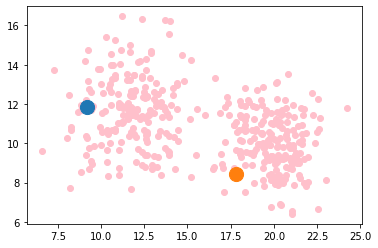

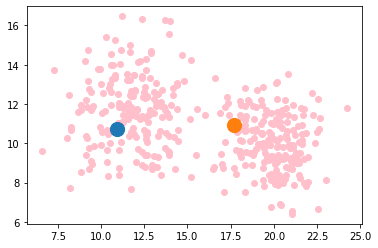

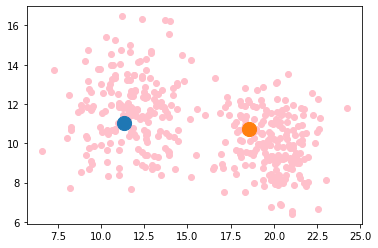

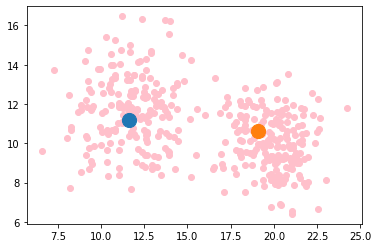

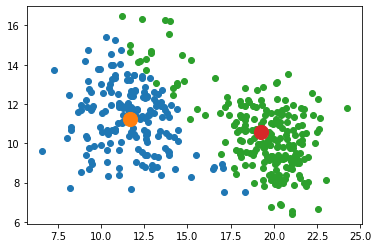

The accuracy for run # 9 is: 0.9225000143051147

Results for "separated clusters shape dataset"
accuracy mean: 0.9275000095367432
accuracy std: 0.005700871688715594
****************************************************
X2 dataset


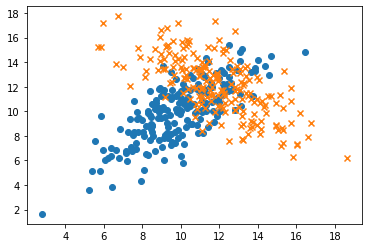

Running X2 dataset with manhattan distance


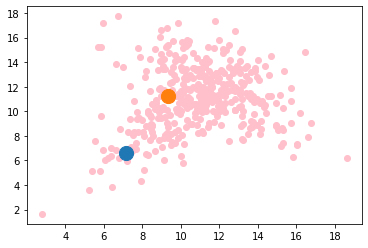

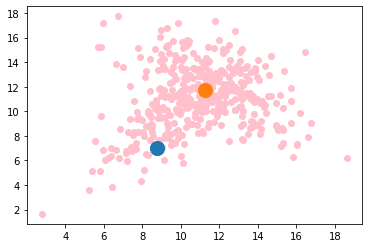

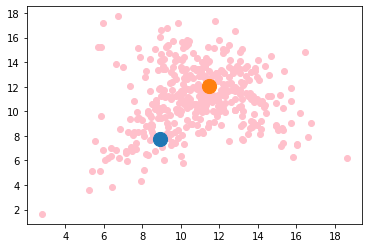

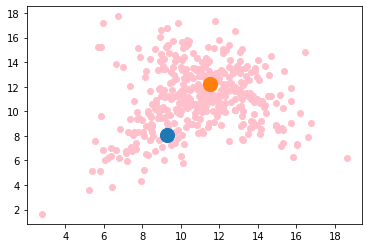

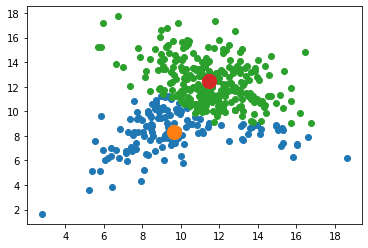

The accuracy for run # 0 is: 0.6949999928474426


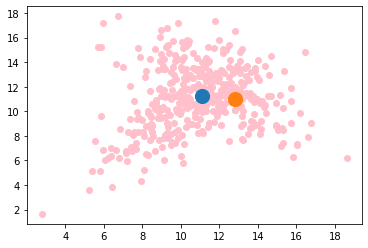

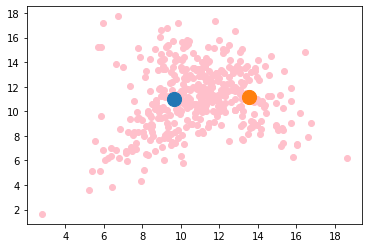

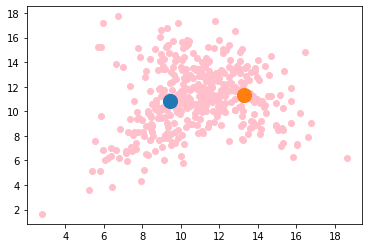

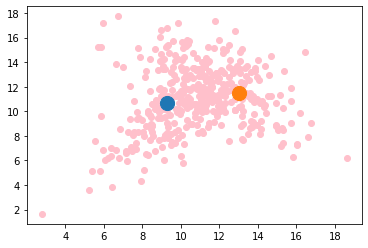

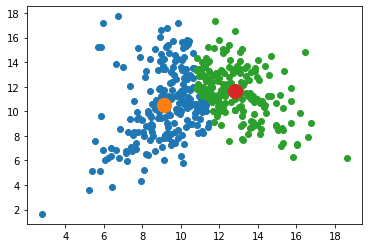

The accuracy for run # 1 is: 0.6899999976158142


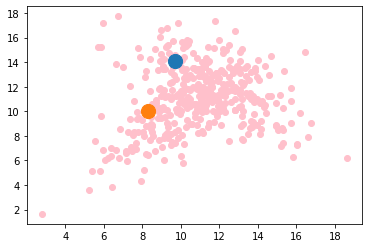

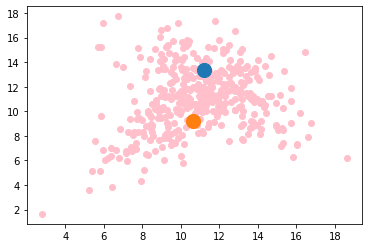

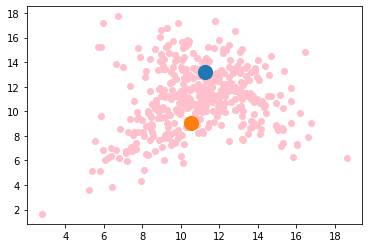

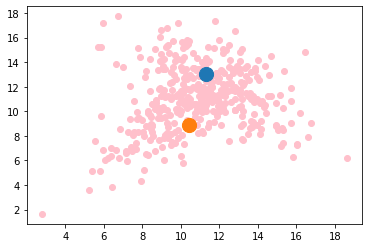

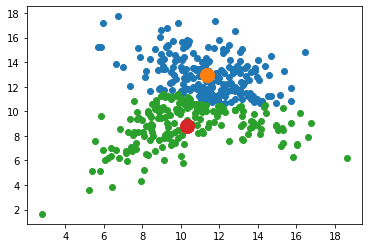

The accuracy for run # 2 is: 0.6949999928474426


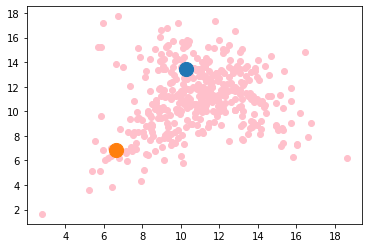

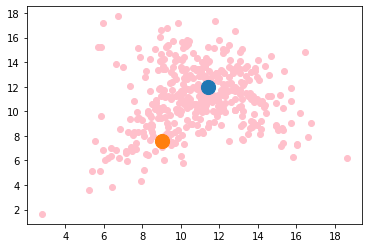

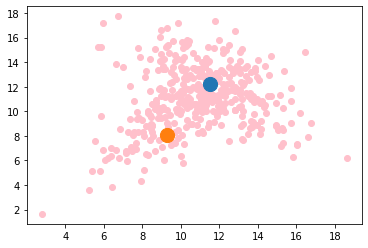

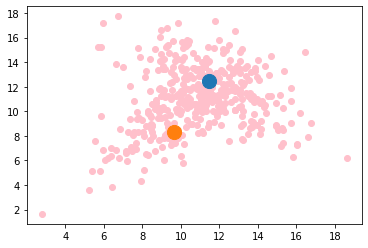

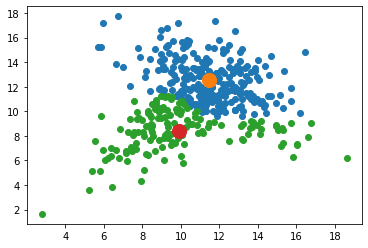

The accuracy for run # 3 is: 0.699999988079071


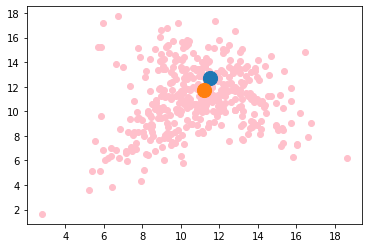

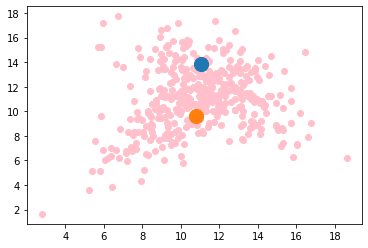

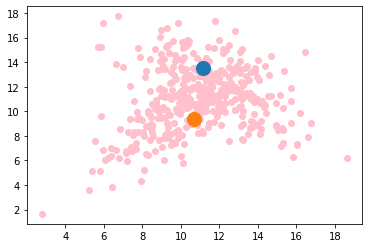

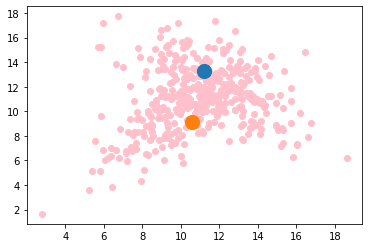

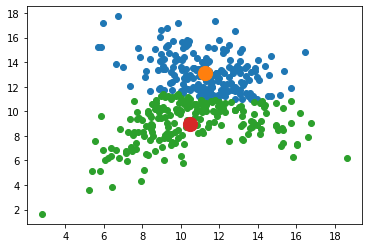

The accuracy for run # 4 is: 0.6850000023841858


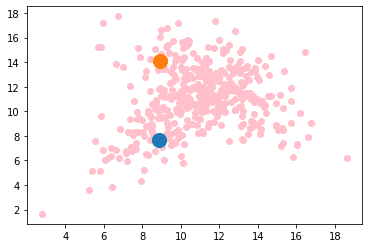

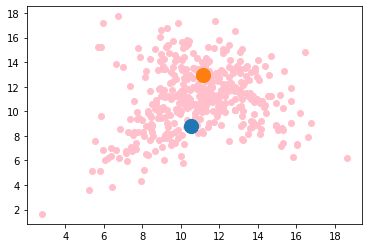

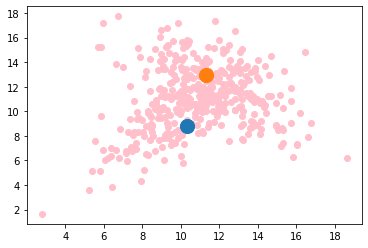

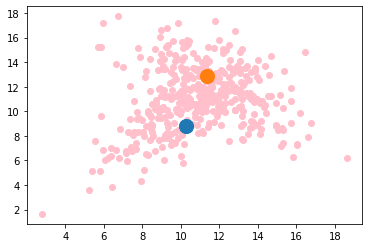

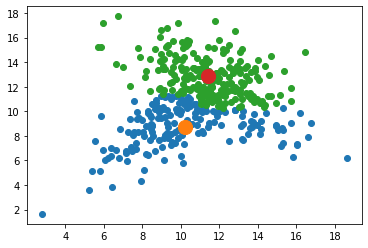

The accuracy for run # 5 is: 0.7024999856948853


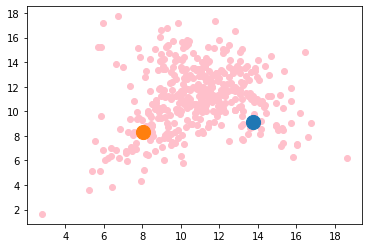

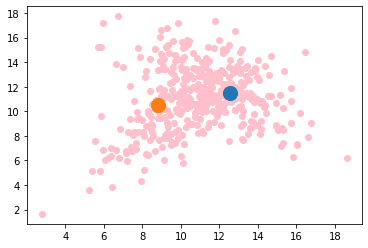

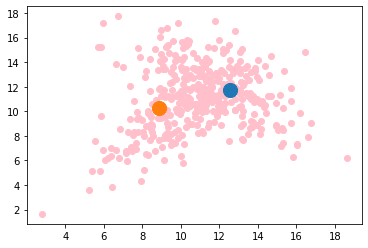

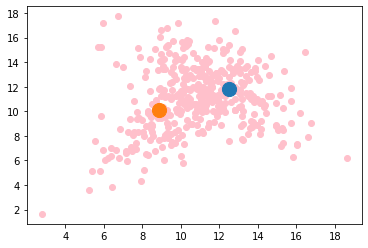

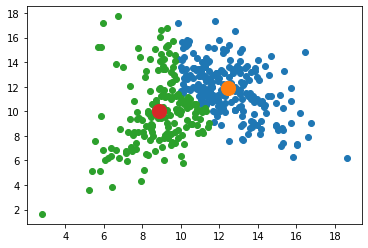

The accuracy for run # 6 is: 0.7300000190734863


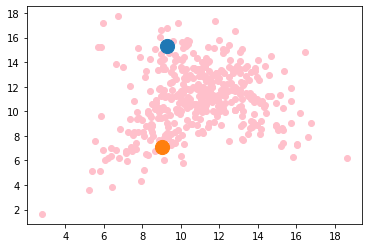

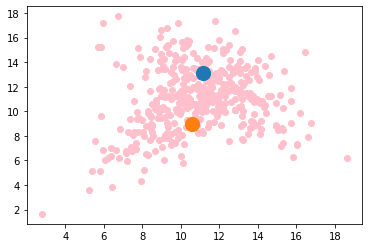

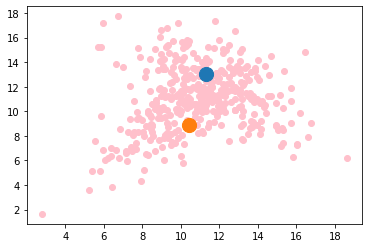

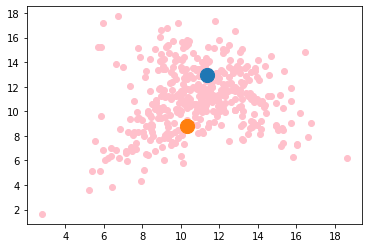

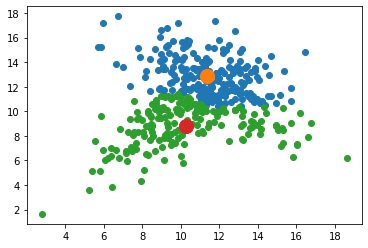

The accuracy for run # 7 is: 0.6949999928474426


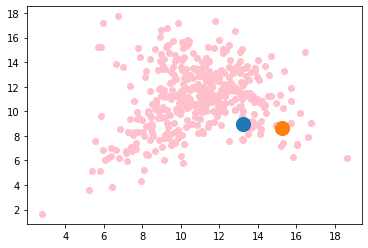

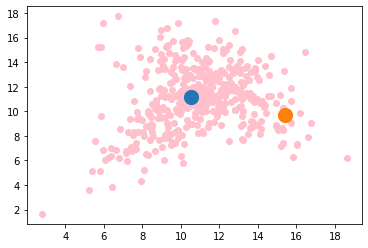

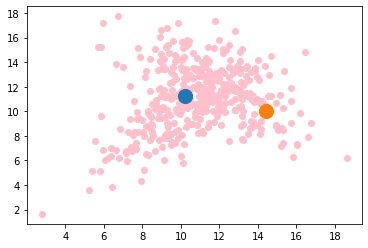

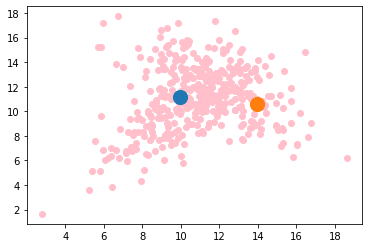

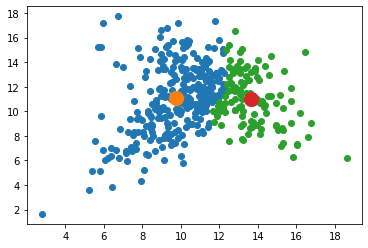

The accuracy for run # 8 is: 0.6474999785423279


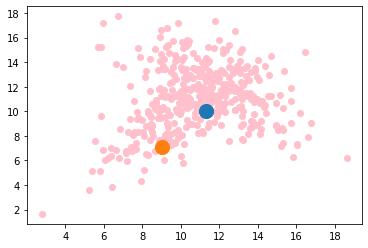

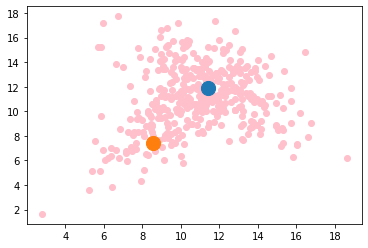

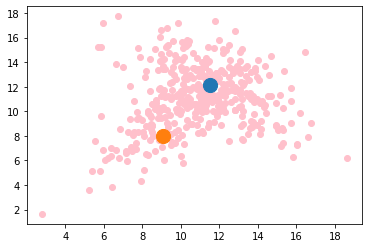

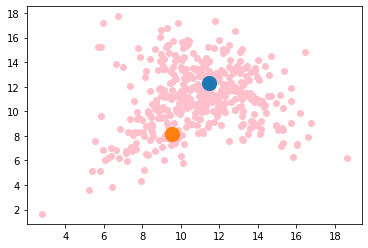

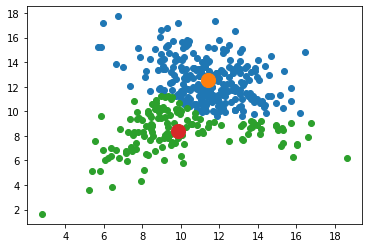

The accuracy for run # 9 is: 0.6899999976158142

Results for "X shape dataset"
accuracy mean: 0.6929999947547912
accuracy std: 0.01916377528053802


In [ ]:
"""
Main function
"""
def main():

    accuracies = []
    
    print("X1 dataset")
    (TargetsAllSeparated, SamplesAllSeparated) = createData(numberSamplesPerClass = 200, mean1 = [12,12], mean2 = [20, 10], stds1 = [3, 3], stds2 = [2, 2])

    print("Running X1 dataset with euclidean distance")
    for i in range(0, 10):
      acc = test_Kmeans(TargetsAllSeparated, SamplesAllSeparated, 2, 4, True)
      print("The accuracy for run #",  i, "is:", acc)
      accuracies.append(acc)
    
    partitions_acc = np.array(accuracies)
    print('')
    print('Results for "separated clusters shape dataset"')
    print('accuracy mean: %s'%(partitions_acc.mean()))
    print('accuracy std: %s'%(partitions_acc.std()))


    # Ejemplo de una X

    covarianceM1 = torch.eye(2)
    covarianceM1[0, 1] = 4
    covarianceM1[1, 0] = 4
    covarianceM2 = torch.eye(2)
    covarianceM2[0, 1] = -4
    covarianceM2[1, 0] = -4

    accuracies = []
    print("****************************************************")
    print("X2 dataset")
    (TargetsAllX, SamplesAllX) = createData(numberSamplesPerClass = 200, mean1 = [10, 10], mean2 = [12, 12], stds1 = [5, 6], stds2 = [5, 6], covarianceMatrix1 = covarianceM1, covarianceMatrix2 = covarianceM2)


    print("Running X2 dataset with manhattan distance")

    for i in range(0, 10):
      acc = test_Kmeans(TargetsAllX, SamplesAllX, 2, 4, False)
      print("The accuracy for run #",  i, "is:", acc)
      accuracies.append(acc)

    partitions_acc = np.array(accuracies)
    print('')
    print('Results for "X shape dataset"')
    print('accuracy mean: %s'%(partitions_acc.mean()))
    print('accuracy std: %s'%(partitions_acc.std()))
    

    
    
main()

# Implementación del algoritmo de Corte de grafos

In [ ]:
import numbers
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

## Algoritmo que genera dos medias lunas

In [ ]:
def check_random_state(seed):
    """
    Turn seed into a np.random.RandomState instance.
    """

    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )


def make_half_moons(samples=100, noise=None, random_state=None):
    """
    Make two half circles/moons.
    """

    if isinstance(samples, numbers.Integral):
        samples_out = samples // 2
        samples_in = samples - samples_out
    else:
        try:
            samples_out, samples_in = samples
        except ValueError as e:
            raise ValueError(
                "samples puede ser un entero o una dupla de dos elementos."
            ) from e

    generator = check_random_state(random_state)

    outer_circ_x = torch.cos(torch.linspace(0, math.pi, samples_out))
    outer_circ_y = torch.sin(torch.linspace(0, math.pi, samples_out))
    inner_circ_x = 1 - torch.cos(torch.linspace(0, math.pi, samples_in))
    inner_circ_y = 1 - torch.sin(torch.linspace(0, math.pi, samples_in)) - 0.5

    X = torch.cat((
                   torch.cat((torch.unsqueeze(outer_circ_x,0), torch.unsqueeze(inner_circ_x,0)), 1), 
                   torch.cat((torch.unsqueeze(outer_circ_y,0), torch.unsqueeze(inner_circ_y,0)), 1)
                  ), 
                  0
                 ).T
    y = torch.cat((
                   torch.zeros(samples_out, dtype=torch.uint8),  
                   torch.ones( samples_in, dtype=torch.uint8)  ), -1)

    #print('X shape: ', X.shape)
    #print('y shape: ', y.shape)
    
    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape) #Original
        #X += torch.normal(X[0]*noise, X[1]*noise  )

    return X, y

## Demostración

X:  torch.Size([400, 2])
y:  torch.Size([400])


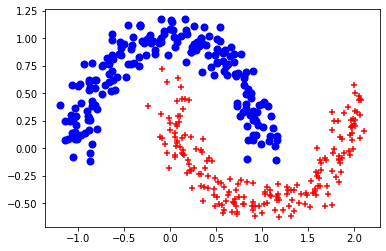

In [ ]:
X, y = make_half_moons((200, 200) , noise=0.1)

print('X: ', X.shape)
print('y: ', y.shape)

plt.scatter(X[y==0, 0], X[y==0, 1], linewidths = 2, color = "blue", marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], linewidths = 2, color = "red",  marker='+')
plt.show()


# Create graph from data points

In [ ]:
# X = torch.FloatTensor([[50, 32],[42, 29],[80, 15],[70, 19], [75, 13]])

adjacency_matrix = torch.zeros(X.shape[0],X.shape[0], dtype=torch.float64)

print(adjacency_matrix.shape)

for i in range(X.shape[0]):
  for j in range(X.shape[0]):
    adjacency_matrix[i][j] = torch.linalg.norm(X[i] - X[j])

print(adjacency_matrix)

torch.Size([400, 400])
tensor([[0.0000, 0.1248, 0.3559,  ..., 1.0756, 1.0945, 1.0544],
        [0.1248, 0.0000, 0.3032,  ..., 1.0243, 1.0287, 0.9945],
        [0.3559, 0.3032, 0.0000,  ..., 1.2825, 1.2657, 1.2415],
        ...,
        [1.0756, 1.0243, 1.2825,  ..., 0.0000, 0.1393, 0.0835],
        [1.0945, 1.0287, 1.2657,  ..., 0.1393, 0.0000, 0.0683],
        [1.0544, 0.9945, 1.2415,  ..., 0.0835, 0.0683, 0.0000]],
       dtype=torch.float64)


#Build Prim tree